# Section 4B. Global sensitivity analysis
We present an approach based on {\it global} sensitivity analysis that allows quantifying the additive and nonadditive effect of individual gene dosages on growth variability. Two indices $S_0$ and $\epsilon_T$ quantify such additive and nonadditive ("total order" epistasis) contributions, respectively. The former quantifies the additive part of the variability associated to a gene while the latter quantifies its total contribution, additive and all non-additive effects. From these, we derive the total epistasis which accounts for all, and only, non-additive effects as $\epsilon_T^i = S_T^i-S_0^i$ and its error $(\Delta\epsilon_T^i)^2 = (\Delta S_0^i)^2 +  (\Delta S_T^i)^2 $. 


$ Var(Y) = \sum_i V_i + \sum_{i,j}V_{i,j} + . . . \sum_{i,...,d}V_{i,...,d}$.

Among all possibilities we focus on two: the first order indices:

$S_0^{(i)} = V_i/V(Y)$

which quantify the additive effects that variability of the i-eth gene produces on the variability of growth rate, and the total effect indices

$S_T^{(i)} = \sum_{\Omega i} V_x$ with $\Omega$ containing all indices with i-eth index

that quantify both the linear and non-linear effects.

## 0. Load plotting style and...

In [1]:
from matplotlib import pyplot as plt

SMALL_SIZE =  16 # 16 -> around 7pts (real Res&Size)
MEDIUM_SIZE = 20 # 20 -> around 9pts (real Res&Size)
colors = plt.style.library['seaborn-deep']['axes.prop_cycle'].by_key()['color']

# Set plot style
if 'styleDefault' not in locals():
    styleDefault = plt.rcParams.copy()
    
styleDict    = plt.style.library['seaborn-deep']
styleDict.update( { 'figure.dpi'       : 100.0        })
styleDict.update( { 'figure.facecolor' : (1,1,1,1)    })
styleDict.update( { 'axes.labelsize'   : MEDIUM_SIZE  })
styleDict.update( { 'font.size'        : SMALL_SIZE   })
styleDict.update( { 'axes.titlesize'   : SMALL_SIZE   })
styleDict.update( { 'xtick.labelsize'  : SMALL_SIZE   })
styleDict.update( { 'ytick.labelsize'  : SMALL_SIZE   })
styleDict.update( { 'legend.fontsize'  : SMALL_SIZE   })

for key, value in styleDict.items():
    plt.rcParams[key] = value

## ... load model, bounds and...

In [2]:
import cobra
import numpy as np
from tqdm import tqdm
from datetime import datetime
from multiprocessing import Pool
from matplotlib import pyplot as plt
from QuantitativeMutation import QuantitativeMutation


#Define conversion functions
rxn2mtb  = lambda REACTION:   [mtb for mtb in REACTION.metabolites ]
rxn2gene = lambda REACTION:   [gene for gene in REACTION.genes ]
mtb2rxn  = lambda METABOLITE: [rxn for rxn in METABOLITE.reactions ]
gene2rxn = lambda GENE:       [rxn for rxn in GENE.reactions]


MODEL_NAME  = 'yeast_iND750'
SOLVER_NAME = 'glpk'


#Define minimal medium...
minimal_medium = {}        
minimal_medium.update( {'EX_o2_e' :     2 }) #... oxygen
minimal_medium.update( {'EX_h2o_e' : 9999 }) #... water
minimal_medium.update( {'EX_co2_e' : 9999 }) #... carbon dioxyde
minimal_medium.update( {'EX_nh4_e' : 9999 }) #... ammonia
minimal_medium.update( {'EX_pi_e'  : 9999 }) #... phosphate
minimal_medium.update( {'EX_so4_e' : 9999 }) #... sulphate
minimal_medium.update( {'EX_k_e'   : 9999 }) #... potassium
minimal_medium.update( {'EX_na1_e' : 9999 }) #... sodium

#... and standard medium
std_medium = minimal_medium.copy()
std_medium.update( {  'EX_glc__D_e' : 20 } )


# Load specific metabolic model...
Q = QuantitativeMutation( './metabolic_models/%s.json' % MODEL_NAME , verbose=True)

#... set solver
Q.model.solver = SOLVER_NAME

#... and standard medium
Q.model.medium = std_medium

#... and load maximal bounds
Q.load_bounds('Data_1_bounds_0.10.csv')
Q.reset_dosage()
Q.apply_dosage()

#Compute solution
wt_solution  = Q.optimize()
wt_growthrate= Q.slim_optimize()
print('\nWild-type growth rate %1.3f' % Q.slim_optimize() )

Academic license - for non-commercial use only - expires 2022-08-06
Using license file /home/pyubero/gurobi.lic
Loaded model iND750 from user file.
Biomass reaction id is BIOMASS_SC4_bal
The model has 750 genes and 1266 reactions.
... number of exchange reactions:	116
... number of non-exchange reactions:	1148
Maxbounds loaded from Data_1_bounds_0.10.csv on 2022-05-15 12:20:55.525522.

Wild-type growth rate 0.514


## ... PGS data from the previous section.

In [3]:
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


data = np.load('Data_2_PPS_def_std.npz')
G_std    = data['G_std']  #... Genotype
f_std    = data['f_std']  #... FBA fitness
J_std    = data['J_std']  #... FBA solution fluxes
coef_std = data['B_std']  #... Effect size
R2_std  = data['R2_std'] #... PPS R2

NSAMPLES = G_std.shape[0]
NGENES   = G_std.shape[1]
NFLUXES  = J_std.shape[1]

print('Data laoded.')
print('# samples:\t%d' % NSAMPLES )
print('# genes:  \t%d' % Q.N_GENES )
print('R2 of PPS: \t%1.4f' % R2_std )


B_THRESHOLD =0.01 

#... find genes with large/small effect
large = np.argwhere(  B_THRESHOLD < np.abs(coef_std) )[:,0]
small = np.argwhere(  [ 0<np.abs(value)<B_THRESHOLD for value in coef_std] )[:,0]

#... sort the genes with descending effect size
large_ord = coef_std[large].argsort()[::-1]
small_ord = coef_std[small].argsort()[::-1]

#... concatenate both sets of large and small
values  = np.concatenate( (coef_std[large[large_ord]],coef_std[small[small_ord]]) )
indices = np.concatenate( (large[large_ord], small[small_ord]) )
labels=[ Q.model.genes[idx].name for idx in indices ]

print('N_total   = %d' % len(values) )
print('  N_large = %d' % len(large) )
print('  N_small = %d' % len(small) )
print('  N_null = %d' % (Q.N_GENES-len(large)-len(small) ) )

Data laoded.
# samples:	5000
# genes:  	750
R2 of PPS: 	0.2694
N_total   = 82
  N_large = 32
  N_small = 50
  N_null = 668


## 1a. Compute data matrix
To calculate the indices using the (quasi) Monte Carlo method, the following steps are used:

1. Generate two individuals A and B sampled with respect to the probability distributions of the input variables.
      
2. Build d further individuals $A_{Bi}$, for i = 1,2,...,d, such that the ith parameter of $A_{Bi}$ is equal to the ith parameter of $B$, and the remaining parameters are from $A$.
    
3. The $A$, $B$, and the d $A_{Bi}$ matrices in total specify N(d+2) points in the input space (one for each row). Run the model at each design point in the $A$, $B$, and $A_{Bi}$ matrices, giving a total of d+2 model evaluations – the corresponding $f(A)$, $f(B)$ and $f(A_{Bi})$ values.

In [4]:
import warnings
warnings.filterwarnings('ignore')

Q.VERBOSE = False

# 1b. Load data and ...
I tried computing sobol indices with all the formulas provided in [Saltelli2010]. However, the ones that worked best are the following.

The first order index $S_0^{i}$ is computed as:

$S_0^{i} = \frac{1}{N}\sum_j^N f(B)[f(A_{Bi}) - f(A)] $,

and the total order index $S_T^i$ is computed as:

$S_T^{i} = \frac{1}{2N}\sum_j^N [f(A) - f(A_{Bi})]^2 $,



In [5]:
%%time
data   = np.loadtxt('Data_4_Sobol_matrix.txt', delimiter=';')


NMC, _ = data.shape

print('Number of samples %d' % NMC )
print('Number of nans %d' % np.sum(np.isnan(data)) )
print('')

Number of samples 119919
Number of nans 0

CPU times: user 1min 10s, sys: 4.24 s, total: 1min 14s
Wall time: 1min 24s


## ... check convergence between f(A) and f(B), and...

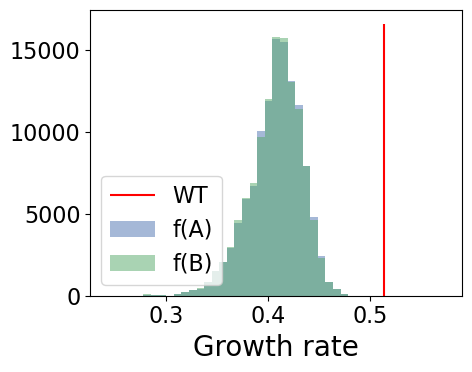

In [6]:
xx = np.linspace(0.8*np.min(data), 1.2*np.max(data),50)

plt.figure( figsize=(5,4), dpi=100 )
plt.hist( data[:,0] , alpha=0.5, bins=xx)
plt.hist( data[:,1] , alpha=0.5, bins=xx)
plt.vlines(wt_growthrate, 0,np.max(plt.ylim()),'r')
plt.xlabel('Growth rate')
plt.legend(('WT','f(A)','f(B)'), loc=3)
plt.xlim( min(xx), max(xx) )

plt.tight_layout();

## ... compute sensitivity indices.

In [7]:
%%time

# Important data matrices
D0 = np.zeros((NMC, Q.N_GENES))
DT = np.zeros((NMC, Q.N_GENES))

# Total variances that we try to explain
#... both values should have converged with growing N.
#VYA = np.var(data[:,0])
#VYB = np.var(data[:,1])
VY = np.var(data[:,:2])

#meanA = np.mean(data[:,0])
#meanB = np.mean(data[:,1])
f0    = np.mean(data[:,:2])


for jj in tqdm(range(Q.N_GENES)):
   
    # Both this formulae appear in the Wikipedia and give reliable results
    D0[:,jj] = ( data[:,1]*( data[:,2+jj] - data[:,0]) )/VY
    DT[:,jj] = ( 0.5*(data[:,0] - data[:,2+jj])**2     )/VY
    
###################################
# The main Sobol indices that we are going to use throughout
S0 = np.mean(D0, axis=0)
ST = np.mean(DT, axis=0)
ET = ST - S0 

eS0 = np.std(D0, axis=0)/np.sqrt(NMC)
eST = np.std(DT, axis=0)/np.sqrt(NMC)
eET = np.sqrt( eS0**2 + eST**2 )

100%|██████████| 750/750 [00:13<00:00, 53.70it/s]


CPU times: user 13 s, sys: 2.75 s, total: 15.8 s
Wall time: 16.3 s


## 2. Show $S_0$ and $\epsilon_T$ for every predictor

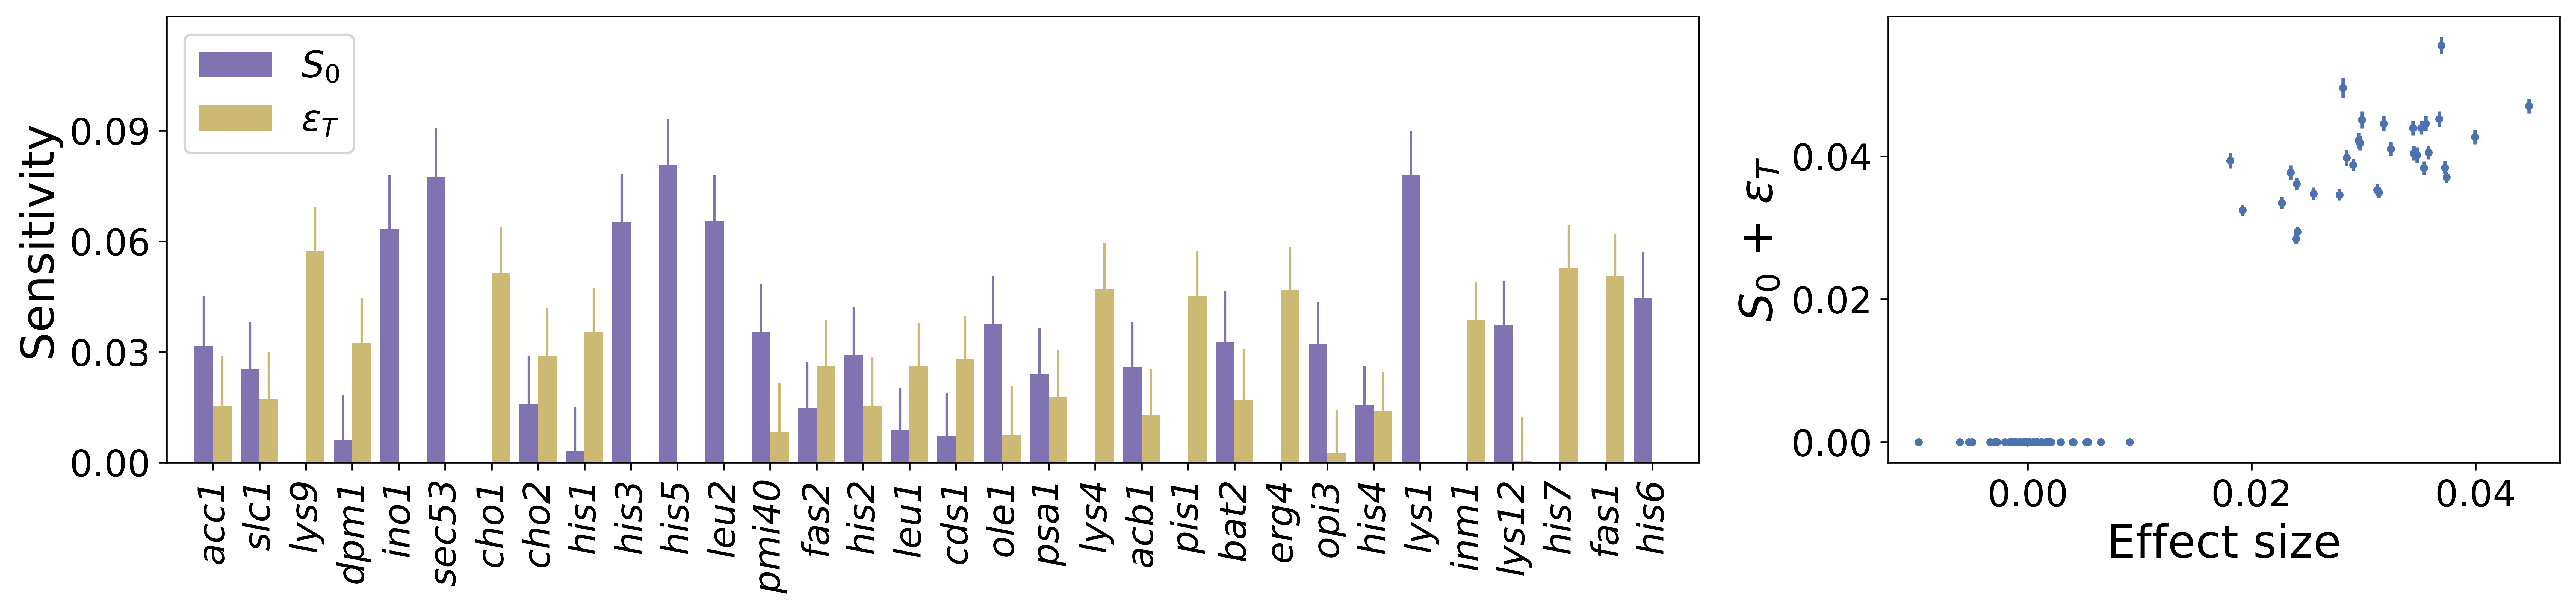

In [8]:
x= np.arange(0,len(large), 1)
labels= [ Q.model.genes.get_by_id(Q.GENES[ii]).name.lower() for ii in large[large_ord] ]
bw = 0.4
_s0 = S0.copy()
_et =ET.copy()
_s0[ S0<0] = np.nan
_et[ ET<0] = np.nan

plt.figure( figsize=(16,4), dpi=600 )

plt.subplot(1,3,(1,2))
plt.bar(x-bw/2,_s0[large[large_ord]], width=bw, color=colors[3] )
plt.bar(x+bw/2,_et[large[large_ord]], width=bw, color=colors[4] , hatch='')
plt.errorbar(x-bw/2,_s0[large[large_ord]],eS0[large[large_ord]],fmt='none', color=colors[3], lw=1 )
plt.errorbar(x+bw/2,_et[large[large_ord]],eET[large[large_ord]],fmt='none', color=colors[4], lw=1 )
plt.legend(('$S_0$','$\epsilon_T$'), loc=2)
plt.ylabel('Sensitivity')
plt.yticks( ticks= np.arange(-0.03,0.12,0.03) )
plt.xticks( ticks= range(len(large)), labels=labels,  style='italic', rotation=90)
plt.xlim(-1, len(large))
plt.ylim(0.0,0.121)


plt.subplot(1,3,3)
#ax = plt.gca().inset_axes([0.5, 0.8, 0.15, 0.15])
#ax.errorbar( coef_std, ST, eST, fmt='.', ms=5)
#ax.set_xlabel('Effect size')
#ax.set_ylabel('$S_0$ + $\epsilon_T$')
#ax.set_xticks( ticks=np.arange(0,0.041,0.02))

plt.errorbar( coef_std, ST, eST, fmt='.', ms=5)
plt.xlabel('Effect size')
plt.ylabel('$S_0$ + $\epsilon_T$')
plt.xticks( ticks=np.arange(0,0.041,0.02))


plt.tight_layout();




### [Supplementary figure] $S_0$, $\epsilon_T$ and $S_T$ correlate with effect sizes.

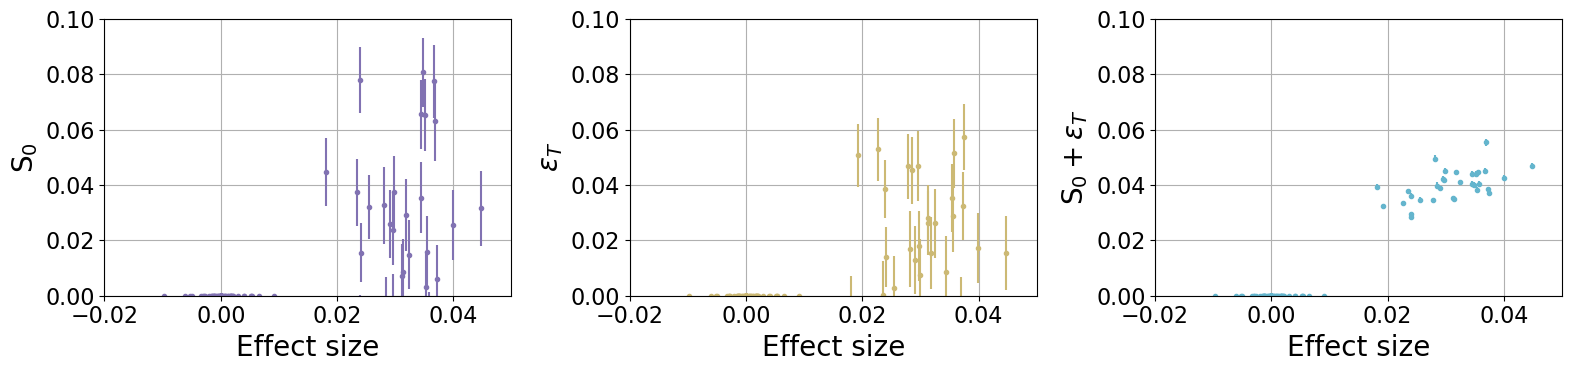

Correlation considering all genes:
rho of So 0.6297
rho of ET 0.4784
rho of ST 0.9781
Correlation considering only top predictors:
rho of So 0.1872
rho of ET -0.0845
rho of ST 0.5722


In [9]:
plt.figure( figsize=(16,4) )

plt.subplot(1,3,1)
plt.errorbar( coef_std , S0 ,eS0, fmt='.', color=colors[3])
plt.grid()
plt.xlabel('Effect size')
plt.ylabel(r'S$_0$')
plt.ylim(0,0.10)
plt.xlim(-0.02, 0.05)

plt.subplot(1,3,2)
plt.errorbar( coef_std , ET ,eET, fmt='.', color=colors[4])
plt.grid()
plt.xlabel('Effect size')
plt.ylabel('$\epsilon_T$')
plt.ylim(0,0.10)
plt.xlim(-0.02, 0.05)

plt.subplot(1,3,3)
plt.errorbar( coef_std , ST ,eST, fmt='.', color=colors[5])
plt.xlabel('Effect size')
plt.ylabel('S$_0 + \epsilon_T$')
plt.ylim(0,0.10)
plt.xlim(-0.02, 0.05)
plt.grid()


plt.tight_layout()
plt.show();

print('Correlation considering all genes:')
print('rho of So %1.4f' % np.corrcoef(coef_std, S0)[0,1] )
print('rho of ET %1.4f' % np.corrcoef(coef_std, ET)[0,1] )
print('rho of ST %1.4f' % np.corrcoef(coef_std, ST)[0,1] )

print('Correlation considering only top predictors:')
print('rho of So %1.4f' % np.corrcoef(coef_std[large], S0[large])[0,1] )
print('rho of ET %1.4f' % np.corrcoef(coef_std[large], ET[large])[0,1] )
print('rho of ST %1.4f' % np.corrcoef(coef_std[large], ST[large])[0,1] )

## 3. What is behind large $S_0$ or large $\epsilon_T$?

### Is $S_0$ related to the number of precursors that each gene alters?

In [10]:
#.......................        
# Gene-reactions matrix
GxR = np.zeros((Q.N_GENES, Q.N_NEX_RXNS))
for jj, geneid in enumerate( Q.GENES ):
    generxns = Q.model.genes.get_by_id(geneid).reactions
    for rxn in generxns:
        rxnidx = np.argwhere( rxn.id == Q.NEX_RXNS )[0][0]
        GxR[jj, rxnidx] = 1


#..................................        
# Gene-biomass *precursors* matrix
biomass_rxn =  Q.model.reactions.get_by_id( Q.BIOMASS_ID )
biomass_mtb       = [ mtb      for mtb, value in biomass_rxn.metabolites.items() if value<0]
biomass_mtb_id    = np.array( [ mtb.id   for mtb in biomass_mtb ] )
biomass_mtb_name  = np.array( [ mtb.name for mtb in biomass_mtb ] )

GxB  = np.zeros( (Q.N_GENES,len(biomass_mtb)) )
GxB_ = np.zeros( (Q.N_GENES,len(biomass_mtb)) )
GxB__ = np.zeros( (Q.N_GENES,len(biomass_mtb)) )
for idxgene, geneid in enumerate(Q.GENES):
    for rxn in Q.model.genes.get_by_id(geneid).reactions:
        for mtb, value in rxn.metabolites.items():
            if mtb.id in biomass_mtb_id:
                idxmtb = np.argwhere( mtb.id == biomass_mtb_id)[0][0]
                GxB[idxgene, idxmtb]  += value
                GxB_[idxgene, idxmtb] += np.sign(value)
                GxB__[idxgene, idxmtb] += 1


#..................................        
# Reaction-biomass *precursors* matrix
NMTB= len(biomass_mtb)
RxB = np.zeros((Q.N_NEX_RXNS, NMTB))
for rxn_idx in range(Q.N_NEX_RXNS):
    rxn = Q.model.reactions.get_by_id( Q.NEX_RXNS[rxn_idx] )
    for mtb, CS in rxn.metabolites.items():
        if mtb.id in biomass_mtb_id:
            mtb_idx = np.argwhere( mtb.id == biomass_mtb_id )[0][0]
            RxB[ rxn_idx, mtb_idx ] += CS
            

#.............................        
# Define conversion functions
rxn2mtb  = lambda REACTION:   [mtb for mtb in REACTION.metabolites ]
rxn2gene = lambda REACTION:   [gene for gene in REACTION.genes ]
mtb2rxn  = lambda METABOLITE: [rxn for rxn in METABOLITE.reactions ]
gene2rxn = lambda GENE:       [rxn for rxn in GENE.reactions]

In [11]:
MIN_FLUX = 1e-10
meanJ = np.mean(J_std, axis=0)
fluxes= np.abs(meanJ*GxR)

active_genes = np.argwhere( np.sum(fluxes, axis=1)>MIN_FLUX)[:,0]
print('Number of total active genes: %d' % len(active_genes) )

all_to_list = large
genes_list = Q.GENES[all_to_list]
additive   = S0[all_to_list]
epistasis  = ET[all_to_list]



x1 = np.nan*np.zeros((len(all_to_list),))
x2 = np.nan*np.zeros((len(all_to_list),))
x3 = np.nan*np.zeros((len(all_to_list),))
x4 = np.nan*np.zeros((len(all_to_list),))
x5 = np.nan*np.zeros((len(all_to_list),))
x6 = np.nan*np.zeros((len(all_to_list),))


for _, idx in enumerate( all_to_list) :
    
    # Number of reactions that the gene controls
    x1[_] =  np.sum( GxR[idx, :] )
    
    # Number of *active* reactions that the gene controls
    x2[_] = np.sum( np.abs(fluxes[idx,:] )>MIN_FLUX )
    
    # The amount of flux through the reactions that the gene controls
    x3[_] = np.log10( np.sum( np.abs(fluxes[idx,:] )))
    
    # The number of genes in the reactions that the gene controls
    rxn_idc = np.argwhere( GxR[idx,:] )[:,0]
    x4[_] = np.sum( [ len(Q.model.reactions.get_by_id(Q.NEX_RXNS[jj]).genes) for jj in rxn_idc ])
    
    # The number of genes in the *active* reactions that the gene controls
    rxn_idc = np.argwhere( np.abs(fluxes[idx,:])> MIN_FLUX )[:,0]
    x5[_] = np.sum( [ len(Q.model.reactions.get_by_id(Q.NEX_RXNS[jj]).genes) for jj in rxn_idc ])
    
    
    
print('%+1.3f\t%+1.3f' % ( np.corrcoef(S0[all_to_list], x1)[0,1] , np.corrcoef(ET[all_to_list], x1)[0,1] ) )
print('%+1.3f\t%+1.3f' % ( np.corrcoef(S0[all_to_list], x2)[0,1] , np.corrcoef(ET[all_to_list], x2)[0,1] ) )
print('%+1.3f\t%+1.3f' % ( np.corrcoef(S0[all_to_list], x3)[0,1] , np.corrcoef(ET[all_to_list], x3)[0,1] ) )
print('%+1.3f\t%+1.3f' % ( np.corrcoef(S0[all_to_list], x4)[0,1] , np.corrcoef(ET[all_to_list], x4)[0,1] ) )
print('%+1.3f\t%+1.3f' % ( np.corrcoef(S0[all_to_list], x5)[0,1] , np.corrcoef(ET[all_to_list], x5)[0,1] ) )
    

Number of total active genes: 432
-0.186	+0.189
-0.105	+0.119
+0.227	-0.224
-0.163	+0.168
-0.126	+0.137
